In [3]:
import numpy as np
import yfinance as yf
import pandas as pd
import scipy.optimize as sco
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds   
import os 

In [4]:
# TDL : 
# strat update de la cov
# checker le calcul dynamique des poids 
# calculer les metrics de mon portefeuille 

# créer un module avec les fonctions utiles

# add transaction costs and volatility scaling cf. 4.4 dans l'article 

In [5]:
# article du papier, (préférer celui de CHOUEIFATY - Toward Maximum Diversification)
# https://www.tandfonline.com/doi/epdf/10.1080/23322039.2018.1427533?needAccess=true

In [1]:
# Data loading 

# from 2006 to 2020 daily 
# test from 2011 to end of april 2020

tickers = ['VTI', 'AGG', 'DBC', '^VIX']
start = "2006-01-01"
end = "2020-12-31"
period = "1d"
window = 50

df_original = yf.download(tickers, start=start, end=end, period=period)['Adj Close']
df_original.index = df_original.index.strftime("%Y-%m-%d")

In [19]:
# un court check sur DBC

for col in df_original.columns:
    print(df_original[col].first_valid_index())

2006-01-03
2006-02-06
2006-01-03
2006-01-03


In [23]:
# data cleaning & creating rets and ma
df = df_original.copy()

cols_rets = [f"{asset}_r" for asset in tickers]
df[cols_rets] = df[tickers].pct_change()

cols_mavg = [f"{col}_mavg_50d" for col in cols_rets]
df[cols_mavg] = df[cols_rets].rolling(window=window).mean()

cols_vol = [f"{col}_vol_50d" for col in cols_rets]
df[cols_vol] = df[cols_rets].rolling(window=window).std()

df_with_na = df.copy() 
df.dropna(inplace=True)

df

Ticker,AGG,DBC,VTI,^VIX,VTI_r,AGG_r,DBC_r,^VIX_r,VTI_r_mavg_50d,AGG_r_mavg_50d,DBC_r_mavg_50d,^VIX_r_mavg_50d,VTI_r_vol_50d,AGG_r_vol_50d,DBC_r_vol_50d,^VIX_r_vol_50d
Date,,,,,,,,,,,,,,,,
2006-04-19,55.700787,22.356941,46.467957,11.320000,0.002987,0.000915,0.009747,-0.007018,0.000813,-0.000212,0.001441,-0.001952,0.005784,0.002232,0.012977,0.042051
2006-04-20,55.615814,22.097979,46.531864,11.640000,0.001375,-0.001526,-0.011583,0.028269,0.001035,-0.000229,0.001788,-0.002230,0.005581,0.002239,0.012366,0.041798
2006-04-21,55.610210,22.564108,46.510571,11.590000,-0.000458,-0.000101,0.021094,-0.004296,0.000882,-0.000221,0.002295,-0.001198,0.005513,0.002238,0.012630,0.041076
2006-04-24,55.819656,22.115244,46.375698,11.750000,-0.002900,0.003766,-0.019893,0.013805,0.000862,-0.000157,0.001709,-0.001374,0.005525,0.002306,0.012968,0.040991
2006-04-25,55.632835,22.184299,46.226639,11.750000,-0.003214,-0.003347,0.003123,0.000000,0.000757,-0.000182,0.002136,-0.000993,0.005552,0.002334,0.012647,0.040911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,106.353706,13.794738,182.168045,23.309999,0.001710,-0.000679,0.012517,-0.037969,0.001588,0.000074,0.001958,-0.000181,0.010220,0.001907,0.009066,0.065785
2020-12-24,106.452942,13.832635,182.472794,21.530001,0.001673,0.000933,0.002747,-0.076362,0.001754,0.000080,0.001877,-0.001961,0.010150,0.001910,0.009040,0.066630
2020-12-28,106.470993,13.747366,183.627319,21.700001,0.006327,0.000170,-0.006164,0.007896,0.001874,0.000101,0.001693,-0.002235,0.010169,0.001905,0.009109,0.066559


In [25]:
# covariance annualisée sur toute la période 

cov = df[cols_mavg].cov()
cov * 252 

Ticker,VTI_r_mavg_50d,AGG_r_mavg_50d,DBC_r_mavg_50d,^VIX_r_mavg_50d
Ticker,,,,
VTI_r_mavg_50d,0.000567,0.000004,0.000445,-0.002333
AGG_r_mavg_50d,0.000004,0.000029,-0.000016,-0.000054
DBC_r_mavg_50d,0.000445,-0.000016,0.000998,-0.002065
^VIX_r_mavg_50d,-0.002333,-0.000054,-0.002065,0.017095


In [72]:
# fonctions qui calculent les poids de la strat 

def diversification_ratio(w, cov):
    sigma = np.sqrt(np.diag(cov))
    wT_sigma = w.T @ sigma 
    wT_cov_w = w.T @ cov @ w 
    return wT_sigma / (np.sqrt(wT_cov_w))

def get_weights_md(cov, bounds=None):
    """
    We get the weights for period t by minimizing the negative diversification ratio with cov matrix computed at time (t - 1)  
    """
    n_assets = cov.shape[0]
    w0 = np.ones(n_assets) / n_assets 

    # Defining the loss and the weight constraint
    
    def loss(w, cov):
        return - diversification_ratio(w, cov)

    def constraint(w):
        return w.sum() - 1 
    
    cons = {'type': 'eq', 'fun': constraint}
            
    res = minimize(
        fun = loss,
        x0 = w0,
        constraints=cons,
        args=cov,
        bounds=bounds,
        method='SLSQP'
    )

    return res.x  

In [75]:
# exemple 

get_weights_md(cov)

array([0.31060094, 0.5348875 , 0.08393792, 0.07057364])

In [182]:
def optimize_portfolio_md(returns, rolling_window=50, bounds=None):
    """
    Prend en entrée le df des returns et retourne un df avec poids de la stratégie
    avec les covariances estimées sur la fenêtre donnée en input 

    on prends la matrice de cov à une date t et ça nous donne les poids pour la date (t+1)

    """
    # check valid input  

    if not isinstance(returns, pd.DataFrame):
        raise ValueError("please input returns as a dataframe") 

    _, n_assets = returns.shape

    # ensuring we have a datetime index 

    if not np.issubdtype(returns.index.dtype, np.datetime64):
        returns.index = pd.to_datetime(returns.index)

    # computing the rolling cov

    cov_rolling = returns.rolling(window=rolling_window).cov().dropna()
    
    # extracting the unique date index from the multindex 

    dates = cov_rolling.index.get_level_values('Date').unique()
    n_dates = len(dates)


    # initializing the weight matrix 

    weights_matrix_df = pd.DataFrame(np.zeros(shape=(n_dates, n_assets)))
    weights_matrix_df.index = dates 
    weights_matrix_df.columns = cov_rolling.columns 

    for i, date in enumerate(dates):
        cov = cov_rolling.loc[date]
        weights_matrix_df.iloc[i] = get_weights_md(cov, bounds=bounds)

    return weights_matrix_df.shift(1).dropna() # se poser la question de si on peut garder plus de dates 


    

In [183]:
returns = df[cols_rets] 
bounds = tuple((0, 1) for _ in range(4))
weights_matrix = optimize_portfolio_md(returns, bounds=bounds, rolling_window=window)

Ticker,VTI_r,AGG_r,DBC_r,^VIX_r
Date,,,,
2006-06-29,0.665719,0.215386,0.053393,0.065501
2006-06-30,0.684587,0.196154,0.049869,0.069390
2006-07-03,0.696140,0.186288,0.047209,0.070362
2006-07-05,0.705807,0.187856,0.034765,0.071571
2006-07-06,0.723757,0.165870,0.037021,0.073352
...,...,...,...,...
2020-12-23,0.300252,0.566615,0.078814,0.054319
2020-12-24,0.295406,0.563534,0.086996,0.054063
2020-12-28,0.288835,0.574265,0.084724,0.052175


In [191]:
# saving the weights

path_dir = os.getcwd()
version = 2
name_output = f"weights_md_{version}.csv"
path = path_dir + "\\output\\" + name_output
weights_matrix.to_csv(path)

In [192]:
# checking the weights are 1 

weights_matrix_check = np.isclose(weights_matrix.iloc[:, 0:4].sum(axis=1), 1.0, atol=1e-6)

all_rows_valid = weights_matrix_check.all()
print("All rows sum to 1" if all_rows_valid else "Some rows do not sum to 1.")

weights_matrix

All rows sum to 1


Ticker,VTI_r,AGG_r,DBC_r,^VIX_r
Date,,,,
2006-06-29,0.665719,0.215386,0.053393,0.065501
2006-06-30,0.684587,0.196154,0.049869,0.069390
2006-07-03,0.696140,0.186288,0.047209,0.070362
2006-07-05,0.705807,0.187856,0.034765,0.071571
2006-07-06,0.723757,0.165870,0.037021,0.073352
...,...,...,...,...
2020-12-23,0.300252,0.566615,0.078814,0.054319
2020-12-24,0.295406,0.563534,0.086996,0.054063
2020-12-28,0.288835,0.574265,0.084724,0.052175


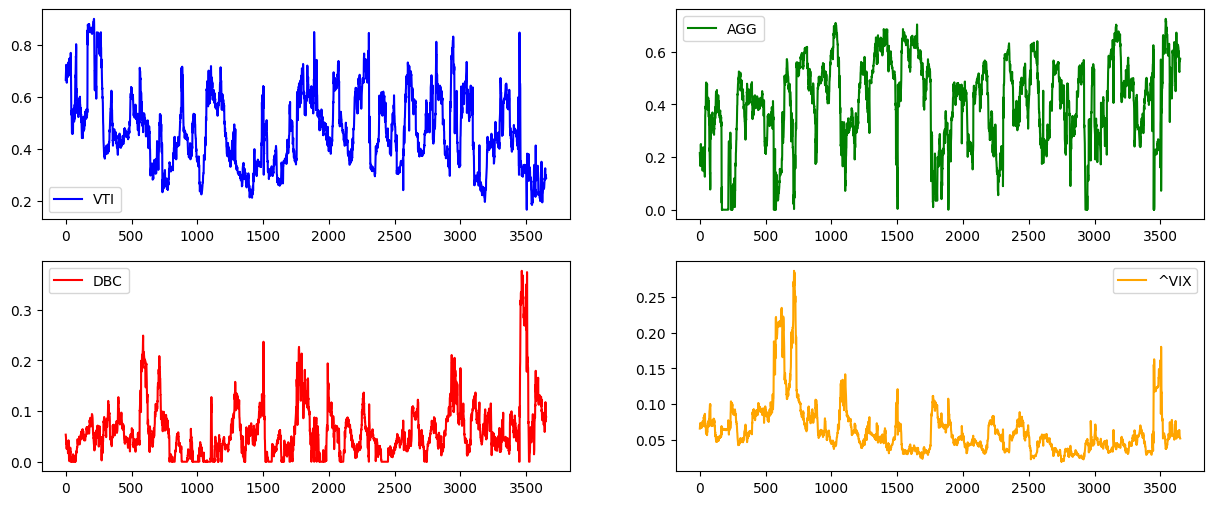

In [193]:
fig, axs = plt.subplots(2,2, figsize=(15, 6))
colors = ['blue', 'green', 'red', 'orange']
axs = axs.flatten()
for i in range(len(axs)):
    axs[i].plot(weights_matrix.iloc[:,i].values, label=tickers[i], color=colors[i])
    axs[i].legend()

In [194]:
weights_matrix

Ticker,VTI_r,AGG_r,DBC_r,^VIX_r
Date,,,,
2006-06-29,0.665719,0.215386,0.053393,0.065501
2006-06-30,0.684587,0.196154,0.049869,0.069390
2006-07-03,0.696140,0.186288,0.047209,0.070362
2006-07-05,0.705807,0.187856,0.034765,0.071571
2006-07-06,0.723757,0.165870,0.037021,0.073352
...,...,...,...,...
2020-12-23,0.300252,0.566615,0.078814,0.054319
2020-12-24,0.295406,0.563534,0.086996,0.054063
2020-12-28,0.288835,0.574265,0.084724,0.052175


In [204]:
# getting the returns of the MD portfolio for the selected dates 

start_period = "2011-03-16"
end_period = "2020-04-29"

selected_returns = returns.loc[start_period:end_period]

common_dates = selected_returns.index.intersection(weights_matrix.index)

weighted_returns = weights_matrix.loc[common_dates] * selected_returns.loc[common_dates]
portfolio_md_rets = weighted_returns.sum(axis=1).to_frame("portfolio_md_rets")
portfolio_md_rets["cumulative_rets"] = (1 + portfolio_md_rets.loc[:,"portfolio_md_rets"]).cumprod() - 1 
portfolio_md_rets

,portfolio_md_rets,cumulative_rets
Date,,
2011-03-16,0.004024,0.004024
2011-03-17,0.000759,0.004787
2011-03-18,-0.001714,0.003065
2011-03-21,-0.000973,0.002089
2011-03-22,-0.002909,-0.000826
...,...,...
2020-04-23,-0.002024,1.275286
2020-04-24,-0.015975,1.238938
2020-04-27,-0.010090,1.216346


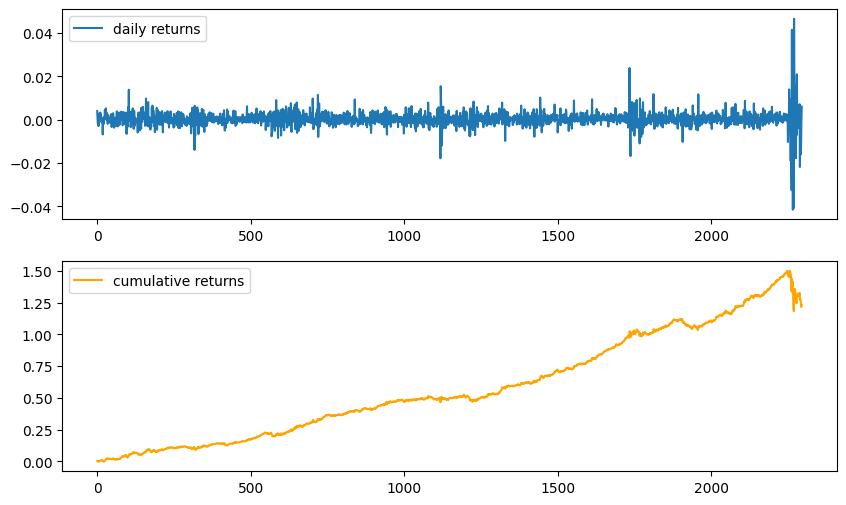

In [205]:
fig, axs = plt.subplots(2,1, figsize=(10, 6))

axs[0].plot(portfolio_md_rets["portfolio_md_rets"].values, label="daily returns")
axs[0].legend()
axs[1].plot(portfolio_md_rets["cumulative_rets"].values, label="cumulative returns", color='orange')
axs[1].legend()

In [206]:
portfolio_return = (1 + portfolio_md_rets["portfolio_md_rets"].mean()) ** 252 - 1
portfolio_volatility = portfolio_md_rets["portfolio_md_rets"].std() * np.sqrt(252)
sharpe = portfolio_return / portfolio_volatility

print(f"Annualized Return: {portfolio_return:.2%}")
print(f"Annualized Volatility: {portfolio_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")

Annualized Return: 9.39%
Annualized Volatility: 5.68%
Sharpe Ratio: 1.65


In [220]:
start_period = "2011-03-16"
end_period = "2020-04-29"
selected_period = pd.date_range(start_period, end_period, freq='D')

cost_rate = 0.0001 
vol_tgt = 0.1


# computing all the volatilites 

vol_50d = returns.rolling(window=50).std() # il faut pondérer exp 
vol_shift_1  = vol_50d.shift(1)
vol_shift_2  = vol_50d.shift(2)

# computing the shifted weights 

weights_shift_2 = weights_matrix.shift(1)

# identifying the common dates 

common_dates = vol_shift_1.index.intersection(weights_matrix.index).intersection(selected_period)

# computing the cost 

cost = cost_rate * vol_tgt * (weights_matrix.loc[common_dates] / vol_shift_1.loc[common_dates] - weights_shift_2.loc[common_dates] / vol_shift_2.loc[common_dates]).sum(axis=1)



returns_portfolio_mod =  vol_tgt * (weights_matrix.loc[common_dates] * selected_returns.loc[common_dates] / vol_shift_1.loc[common_dates]).sum(axis=1) - cost

portfolio_md_rets["portfolio_md_rets_mod"] = returns_portfolio_mod
portfolio_md_rets["cumulative_rets_mod"] = (1 + portfolio_md_rets.loc[:,"portfolio_md_rets_mod"]).cumprod() - 1 

portfolio_md_rets

,portfolio_md_rets,cumulative_rets,portfolio_md_rets_mod,cumulative_rets_mod
Date,,,,
2011-03-16,0.004024,0.004024,0.003954,0.003954
2011-03-17,0.000759,0.004787,0.000892,0.004850
2011-03-18,-0.001714,0.003065,-0.001666,0.003176
2011-03-21,-0.000973,0.002089,-0.001041,0.002131
2011-03-22,-0.002909,-0.000826,-0.002842,-0.000717
...,...,...,...,...
2020-04-23,-0.002024,1.275286,-0.002022,1.279364
2020-04-24,-0.015975,1.238938,-0.015976,1.242950
2020-04-27,-0.010090,1.216346,-0.010093,1.220311


In [221]:
portfolio_return = (1 + portfolio_md_rets["portfolio_md_rets_mod"].mean()) ** 252 - 1
portfolio_volatility = portfolio_md_rets["portfolio_md_rets_mod"].std() * np.sqrt(252)
sharpe = portfolio_return / portfolio_volatility

print(f"Annualized Return: {portfolio_return:.2%}")
print(f"Annualized Volatility: {portfolio_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")

Annualized Return: 9.41%
Annualized Volatility: 5.67%
Sharpe Ratio: 1.66


In [209]:
vol_target = 0 
